<a href="https://colab.research.google.com/github/MilizCom/Machine-Learning/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd

# Memuat dataset baru
df = pd.read_csv("Sales_data.csv")

# Memeriksa kolom yang relevan
df = df[['Quantity', 'Total']]  # Mengambil kolom Quantity dan Total
df.head()


,Quantity,Total
0,7,548.9715
1,5,80.2200
2,7,340.5255
3,8,489.0480
4,7,634.3785


In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Tanpa normalisasi
df_no_normalization = df.copy()

# Standardisasi menggunakan StandardScaler
scaler = StandardScaler()
df_standard = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Normalisasi menggunakan MinMaxScaler
minmax_scaler = MinMaxScaler()
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)


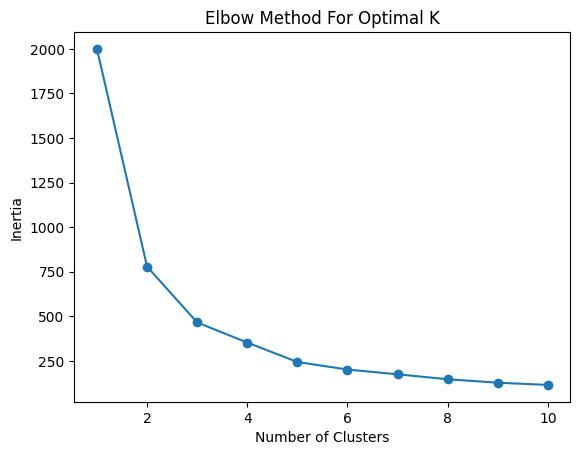

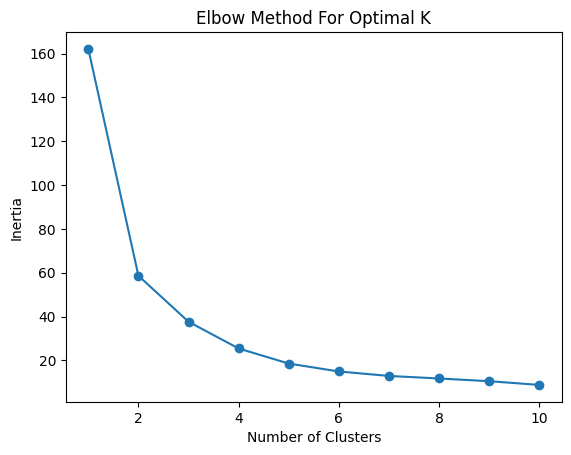

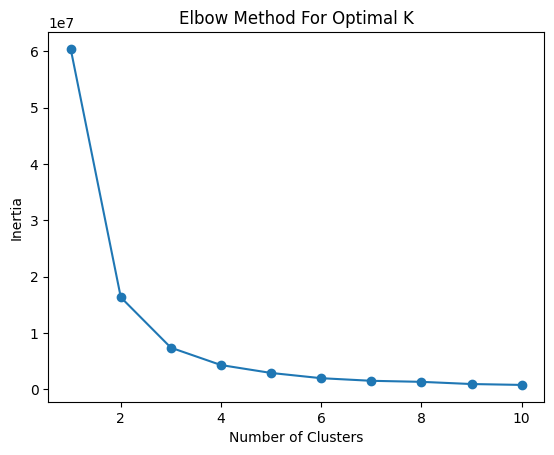

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_elbow(df_normalized, max_k=10):
    inertia = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_normalized)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, max_k+1), inertia, marker='o')
    plt.title("Elbow Method For Optimal K")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.show()

# Menampilkan grafik elbow untuk ketiga jenis normalisasi
plot_elbow(df_standard)
plot_elbow(df_minmax)
plot_elbow(df_no_normalization)


In [25]:
# Misalnya, K optimal adalah 4 berdasarkan metode elbow
k_optimal = 4

def apply_kmeans(df_normalized, k_optimal):
    kmeans = KMeans(n_clusters=k_optimal, random_state=42)
    df_normalized['KMeans_Cluster'] = kmeans.fit_predict(df_normalized)
    return df_normalized

# Terapkan K-Means pada ketiga dataset
df_standard_kmeans = apply_kmeans(df_standard, k_optimal)
df_minmax_kmeans = apply_kmeans(df_minmax, k_optimal)
df_no_normalization_kmeans = apply_kmeans(df_no_normalization, k_optimal)


In [26]:
!pip install fuzzy-c-means # install fuzzy-c-means library, a possible alternative name

In [27]:
from fcmeans import FCM

def apply_fuzzy_cmeans(df_normalized, k_optimal, learning_rate):
    fcm = FCM(n_clusters=k_optimal, m=2.0, max_iter=150, error=0.005, init=None)
    # Convert DataFrame to NumPy array before fitting
    fcm.fit(df_normalized.values)  # Changed line to pass values of the DataFrame
    df_normalized['FCM_Cluster'] = fcm.predict(df_normalized.values) # Changed line to pass values of the DataFrame
    return df_normalized

# Terapkan Fuzzy C-Means dengan berbagai learning rates
df_standard_fcm_05 = apply_fuzzy_cmeans(df_standard.copy(), k_optimal, 0.5)
df_standard_fcm_005 = apply_fuzzy_cmeans(df_standard.copy(), k_optimal, 0.05)
df_standard_fcm_0005 = apply_fuzzy_cmeans(df_standard.copy(), k_optimal, 0.0005)

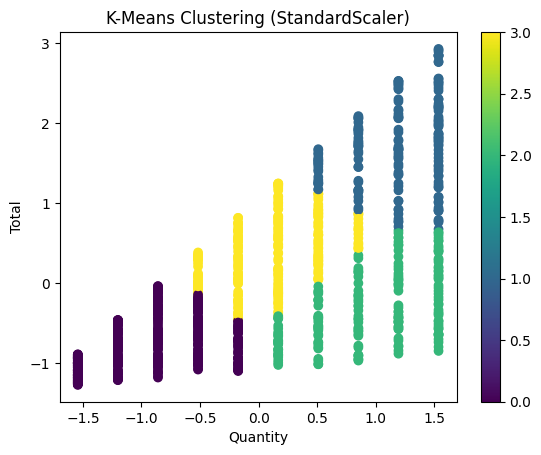

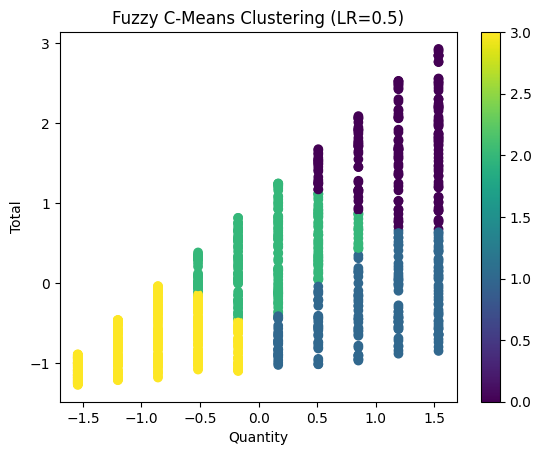

In [28]:
def plot_clusters(df, cluster_col, title):
    plt.scatter(df['Quantity'], df['Total'], c=df[cluster_col], cmap='viridis')
    plt.title(title)
    plt.xlabel('Quantity')
    plt.ylabel('Total')
    plt.colorbar()
    plt.show()

# Visualisasi K-Means dan Fuzzy C-Means
plot_clusters(df_standard_kmeans, 'KMeans_Cluster', 'K-Means Clustering (StandardScaler)')
plot_clusters(df_standard_fcm_05, 'FCM_Cluster', 'Fuzzy C-Means Clustering (LR=0.5)')


In [29]:
from sklearn.metrics import silhouette_score

def compute_silhouette_score(df_normalized, cluster_col):
    return silhouette_score(df_normalized[['Quantity', 'Total']], df_normalized[cluster_col])

# Hitung Silhouette Score untuk ketiga normalisasi
silhouette_kmeans_standard = compute_silhouette_score(df_standard_kmeans, 'KMeans_Cluster')
silhouette_kmeans_minmax = compute_silhouette_score(df_minmax_kmeans, 'KMeans_Cluster')
silhouette_kmeans_no_norm = compute_silhouette_score(df_no_normalization_kmeans, 'KMeans_Cluster')

# Buat tabel hasil silhouette score
silhouette_scores = pd.DataFrame({
    'Normalization': ['StandardScaler', 'MinMaxScaler', 'No Normalization'],
    'Silhouette Score': [silhouette_kmeans_standard, silhouette_kmeans_minmax, silhouette_kmeans_no_norm]
})

silhouette_scores


,Normalization,Silhouette Score
0,StandardScaler,0.459971
1,MinMaxScaler,0.448366
2,No Normalization,0.573507


In [30]:
def compute_learning_rate(df_normalized, learning_rate):
    df_fcm = apply_fuzzy_cmeans(df_normalized, k_optimal, learning_rate)
    return silhouette_score(df_fcm[['Quantity', 'Total']], df_fcm['FCM_Cluster'])

learning_rate_results = {
    0.5: compute_learning_rate(df_standard, 0.5),
    0.05: compute_learning_rate(df_standard, 0.05),
    0.0005: compute_learning_rate(df_standard, 0.0005),
}

learning_rate_df = pd.DataFrame(list(learning_rate_results.items()), columns=['Learning Rate', 'Silhouette Score'])
learning_rate_df


,Learning Rate,Silhouette Score
0,0.5000,0.360264
1,0.0500,0.459087
2,0.0005,0.459087


In [31]:
# Menyimpan hasil clustering ke dalam file CSV
df_no_normalization_kmeans['FCM_Cluster_LR_05'] = df_standard_fcm_05['FCM_Cluster']
df_no_normalization_kmeans.to_csv("cluster_sales.csv", index=False)
